<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT21/blob/main/template-report-Stokes-AMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open template In Colab"/></a>

# **The Stokes equations - adaptive mesh refinement**
**Johan Hoffman**

**Lab made by Miguel De Le Court**

# **Abstract**
This short report uses FEniCS to solve the Stokes equations using adaptive mesh refinement, as part of the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology. 

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [1]:
"""This program is based on an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""
"""The template file is available at https://github.com/johanhoffman/DD2365_VT21"""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'The template file is available at https://github.com/johanhoffman/DD2365_VT21'

# **Set up environment**

In [13]:
# Load neccessary modules.
try:
    from google.colab import files #Unnecessary if ran locally
    ! sudo apt-get install texlive-latex-extra 
    ! sudo apt install texlive-fonts-recommended
    ! sudo apt install dvipng
    ! sudo apt-get install cm-super
except:
    pass

import numpy as np
import time

# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

In [3]:
# Setting up matplotlib to use TeX.
import matplotlib
matplotlib.rc("text", usetex=True)
matplotlib.rc("font", family="serif")
matplotlib.rc('image', cmap="Spectral_r")
usingtex = True
matplotlib.rcParams.update({'font.size': 14})

# **Introduction**

The Stokes equations take the form

$$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$$
u=g_D,\quad x\in \Gamma_D
$$

$$
u=0,\quad x\in \Gamma_F
$$

$$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force. 

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that 

$$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that 

$$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions. 

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero. 

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$, 

$$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$, 
which generates the adjoint Stokes equations

$$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$$

together with boundary conditions that reflect the primal equations and the chosen functional. 

$$
\varphi=0,\quad x\in \Gamma_D
$$

$$
\varphi=\psi_3,\quad x\in \Gamma_F
$$

$$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that 

$$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$$

for all test functions $(v,q) \in V\times Q$. 

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$, 
with the error indicator 

$${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K,$$ 

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible. 

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type 

$$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with 

$$
R_1(U,P) = f + \Delta U - \nabla P
$$

$$
R_2(U) = \nabla \cdot U
$$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

We defined a single function `compute_sol(mesh, Porder, tol=1e-3, maxref=0)` to make all of the computations. This function takes a domain, a tolerance and the maximum number of refinements, and recursively refines the mesh where refinement is needed. The parameter Porder defines the order of the basis functions used for the pressure. The velocity uses basis functions of order `Porder +1`, and the adjoint pressure and velocity use polynomial of one degree higher than their primal counterparts. 

The stucture of `compute_sol` follows the initial template structure.

**Define domain and mesh**
The 

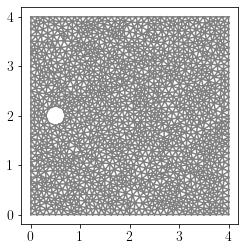

In [4]:
# Define domain 
L = 4
H = 4

# Define circle
xc = 0.5
yc = 0.5*H
rc = 0.2

def genmesh(resolution, xc, yc, rc=0.2):
    # Generate mesh (examples with and without a hole in the mesh) 
    #mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
    mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)
    return mesh

resolution = 32
mesh = genmesh(resolution, xc, yc, rc)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [5]:
def compute_sol(mesh, Porder, tol=1e-3, maxref=0, func=None):
    # Generate mixed finite element spaces (for primal velocity and pressure)
    VE = VectorElement("CG", mesh.ufl_cell(), Porder+1)
    QE = FiniteElement("CG", mesh.ufl_cell(), Porder)
    WE = VE * QE

    W = FunctionSpace(mesh, WE)
    V = FunctionSpace(mesh, VE)
    Q = FunctionSpace(mesh, QE)

    # Define trial and test functions
    w = Function(W)
    (u, p) = (as_vector((w[0],w[1])), w[2])
    (v, q) = TestFunctions(W) 

    # Generate mixed finite element spaces (for adjoint velocity and pressure)
    VEa = VectorElement("CG", mesh.ufl_cell(), Porder+2)
    QEa = FiniteElement("CG", mesh.ufl_cell(), Porder+1)
    WEa = VEa * QEa

    Wa = FunctionSpace(mesh, WEa)
    Va = FunctionSpace(mesh, VEa)
    Qa = FunctionSpace(mesh, QEa)

    # Define adjoint trial and test functions
    wa = Function(Wa)
    (phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
    (va, qa) = TestFunctions(Wa)


    # %% ============================================

    # Examples of inflow and outflow conditions
    XMIN = 0.0; XMAX = L
    YMIN = 0.0; YMAX = H
    uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
    #pout = 0.0

    # Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
    ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
    ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
    wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
    bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

    # %% ============================================

    # Set boundary penalty parameter gamma 
    h = CellDiameter(mesh)
    C = 1.0e3
    gamma = C/h

    # Set force in primal problem
    f = Expression(("0.0","0.0"), element = V.ufl_element())

    # Set data that describe functional that defines the adjoint problem
    #psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
    #psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
    
    if func is None:
        psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
        psi2 = Expression("0.0", element = Q.ufl_element())
        phi3 = Expression(("1.0","0.0"), element = V.ufl_element()) #boundary term
    else:
        E1, E2, E3 = func
        psi1 = Expression(E1, element = V.ufl_element())
        psi2 = Expression(E2, element = Q.ufl_element())
        phi3 = Expression(E3, element = V.ufl_element()) #boundary term

    # Define primal variational problem on residual form: r(u,p;v,q) = 0
    res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

    # Solve primal algebraic system 
    solve(res == 0, w) 

    # Define adjoint variational problem on residual form: r(u,p;v,q) = 0
    res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
            gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds 
            - inner(va, psi1)*dx - qa*psi2*dx )

    # Solve adjoint algebraic system 
    solve(res_a == 0, wa)

    interest_qty = inner(u, psi1)*dx + p*psi2*dx + inner(phi3, u)*ds
    interest_qty = assemble(interest_qty)

    err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
                gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )
    tot_err = assemble(err_ind_sum)
    print("Quantity of interest = %f, total error = %.3e" % (interest_qty, np.abs(tot_err)))

    if maxref > 0 and np.abs(tot_err) > tol:
        # Define function space over the elements of the mesh
        WDG = FunctionSpace(W.mesh(), "DG", 0)
        elm = TestFunction(WDG)
        err_ind = Function(WDG)

        # Compute local error indicators over the cells of the mesh 
        local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx ) 
        err_ind.vector()[:] = assemble(local_error)
        err_ind_abs = np.abs(err_ind.vector())
        err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

        # Local mesh refinement (specified by a cell marker)
        no_levels = 1
        for i in range(0,no_levels):
            cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
            for c in cells(mesh):
                cell_marker[c] = False
                local_error_cell = err_ind_abs[c.index()] 
                if local_error_cell > err_ind_mean:
                    cell_marker[c] = True
        mesh = refine(mesh, cell_marker)
        return compute_sol(mesh, Porder, tol=tol, maxref=maxref-1, func=func)

    return u, p, phi, theta, V, Q, mesh


# **Results**

In [6]:
mesh0 = [genmesh(20, 0.5, 0.5*H), genmesh(20, 0.5*L, 0.5*H), genmesh(20, 0.5*L, 0.85*H), genmesh(20, 0.85*L, 0.85*H)]

results = []
for (i, mesh) in enumerate(mesh0):
    results += [compute_sol(mesh=mesh, Porder=1, tol = 1e-3, maxref=1)]


Quantity of interest = 5.315921, total error = 3.870e-01
Quantity of interest = 5.319781, total error = 1.558e-01
Quantity of interest = 5.316311, total error = 4.722e-02
Quantity of interest = 5.315994, total error = 4.888e-02
Quantity of interest = 5.320790, total error = 2.462e-02
Quantity of interest = 5.321323, total error = 1.385e-02
Quantity of interest = 5.320729, total error = 6.617e-03
Quantity of interest = 5.320762, total error = 9.734e-03


In [7]:
fsize=2
results = np.array(results, dtype=object)
u = results[:,0]
p = results[:,1]
phi = results[:,2]
theta = results[:,3]
V = results[:,4]
Q = results[:,5]
mesh = results[:,6]

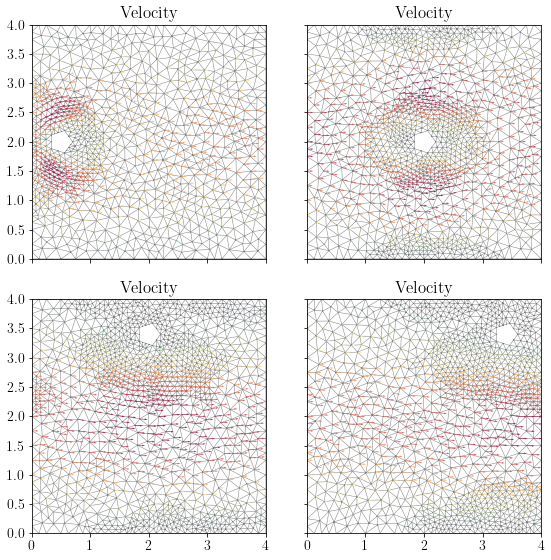

In [8]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(fsize*L, fsize*H))
axes = axes.ravel()
for (i, ref) in enumerate(mesh0):
    plt.sca(axes[i])
    plot(mesh[i], linewidth=0.5, color="k", alpha=0.5)
    plot(u[i], zorder=2)
    plt.title("Velocity")
    plt.xlim((0,L))
    plt.ylim((0,H))
plt.tight_layout()
plt.show()


Moving the center of the circle across the domain results in the configurations above. Since the functionnal used for the adjoint problem describes the force around the cylinder, it is unsurprising that this is where the mesh gets refined. Looking at the adjoint solution below illustrates that the areas that get refined are the ones where the adjoint velocity is large, and this makes sense since $u$ has roughly the same order of magnitude everywhere. What may be surprising however is the areas where that are refined nut not directly connected to the hole. These happen on the boundaries that are not too far from the circle, suggesting that the drag force closely depends on the speed of $u$ on the boundaries.

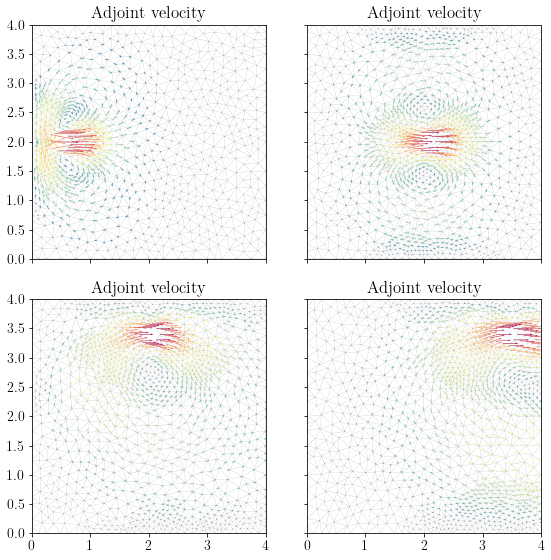

In [9]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(fsize*L, fsize*H))
axes = axes.ravel()
for (i, ref) in enumerate(mesh0):
    plt.sca(axes[i])
    plot(mesh[i], linewidth=0.1, color="k", alpha=0.7)
    plot(phi[i], zorder=2)
    plt.title("Adjoint velocity")
    plt.xlim((0,L))
    plt.ylim((0,H))
plt.tight_layout()
plt.show()


In [10]:
func1 = [("1.0", "0.0"), ("0.0"), ("0.0", "0.0")] #average x-speed
func2 = [("0.0", "0.0"), ("0.0"), ("0.0", "1.0")] #lift force
func3 = [("0.0", "0.0"), ("1.0"), ("0.0", "0.0")] #average pressure
func4 = [("0.0", "0.0"), ("exp(-( pow((x[0]-1), 2.0) + pow((x[1]-2), 2.0))/(0.5*0.5))"), ("0.0", "0.0")] #localised pressure peak 
funcs = [func1, func2, func3, func4]

mesh0 = [genmesh(32, 0.5, 0.5*H), genmesh(20, 0.5*L, 0.5*H), genmesh(20, 0.5*L, 0.85*H), genmesh(20, 0.85*L, 0.85*H)]
results = []
for (i, mesh) in enumerate(mesh0):
    results += [compute_sol(mesh=mesh, Porder=1, tol = 1e-5, maxref=2, func=funcs[i])]

Quantity of interest = 10.635417, total error = 3.327e-05
Quantity of interest = 10.648234, total error = 1.413e-06
Quantity of interest = 0.075487, total error = 2.329e-03
Quantity of interest = -0.000372, total error = 3.764e-04
Quantity of interest = 0.000242, total error = 1.972e-04
Quantity of interest = 22.925569, total error = 2.538e-02
Quantity of interest = 22.990060, total error = 8.825e-03
Quantity of interest = 22.811971, total error = 7.735e-03
Quantity of interest = 1.675056, total error = 1.323e-03
Quantity of interest = 1.684791, total error = 1.491e-03
Quantity of interest = 1.678869, total error = 8.171e-04


In [11]:
fsize=2
results = np.array(results, dtype=object)
u = results[:,0]
p = results[:,1]
phi = results[:,2]
theta = results[:,3]
V = results[:,4]
Q = results[:,5]
mesh = results[:,6]

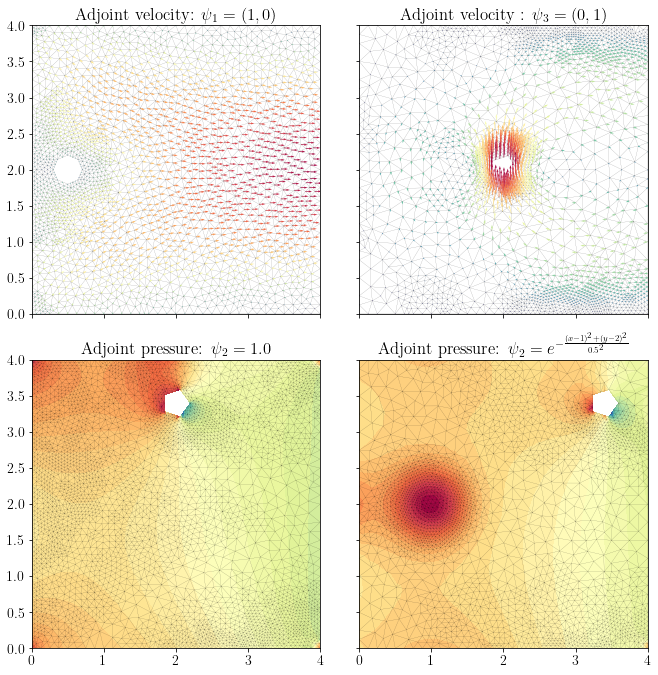

In [12]:
titles = [r"Adjoint velocity: $\psi_1 = (1,0)$", r"Adjoint velocity :  $\psi_3 = (0,1)$",  r"Adjoint pressure:  $\psi_2 = 1.0$", r"Adjoint pressure:  $\psi_2 = e^{-\frac{(x-1)^2 + (y-2)^2}{0.5^2}}$"]
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(1.2*fsize*L, 1.2*fsize*H))
axes = axes.ravel()
for (i, ref) in enumerate(mesh0):
    plt.sca(axes[i])
    plot(mesh[i], linewidth=0.1, color="k", alpha=0.9)
    plot(phi[i], zorder=2) if i < 2 else plot(theta[i])
    plt.title(titles[i])
    plt.xlim((0,L))
    plt.ylim((0,H))
plt.tight_layout()
plt.show()


Changing the functional has somewhat predictable results. On the top left figure, the functinal was set to $\psi_1 = (1,0)$, meaning that we integrate the error in $u_x$. This has the effect of refining the mesh around the generally interesting areas such as the hole or the laft corners. Setting the functionnal to $\psi_3 = (0,1)$, i.e. computing the lift force (top right), has similar effects to previously when whe looked at the drag. Setting a constant value or the pressure (bottom left) also has the same general effect of refinig interesting areas, although in a more diffuse way. Finally, setting a local source in the adjoint pressure naturally increases the resolution around this source, as seen in the bottom right plot.

Regarding the adaptive algorithm, it is worth mentionning that the first (rough) computed error is often lower than the error in the next iteration. 

# **Discussion**
An adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D and recursively refine the mesh until a certain tolerance is reached. The adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define the error indicator over the mesh.